In [54]:
## NF Beammapping test flights with reference antenna in Wright Lab Connector (Sep 16 2022)
## Channel 0 = Bicolog 30100 Antenna, set up NS polarized ~11m West of dish
## Channel 1 = 3m Dish with Vivaldi Antenna NS polarization

##From loadD3Adata_Dallas.py:
from matplotlib.pyplot import *
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator
import numpy as np
import h5py
##From WT:
import datetime
import pytz
import os
import glob
from matplotlib import colors
import pandas
import csv
%matplotlib inline
import pygeodesy

from beamcals import corr
from beamcals import concat
from beamcals import drone
from beamcals import bicolog
from beamcals import reduce_ccclass
import beamcals.plotting_utils as pu
import beamcals.fitting_utils as fu
import beamcals.geometry_utils as gu
import beamcals.time_utils as tu
import beamcals.reduce_ccclass as rc
from beamcals.sites import site
wlcsiteEW=site.site('../beamcals_venv/newburghlabdrone/beamcals/beamcals/sites/WLC_config_EW20230519.npz')
wlcsiteNS=site.site('../beamcals_venv/newburghlabdrone/beamcals/beamcals/sites/WLC_config_NS20230519.npz')

#phase unwrap:
from skimage.restoration import unwrap_phase

# Display settings:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [55]:
## Define functions for the reactive NF, FF, and range of the radiating NF [all units cm]:
    #inputs are dish diameter (D) and wavelength (Lambda) both in cm!
    
def Reactive_NF_Distance_m(D,Lambda):
    return (1.0/100.0)*0.62*np.sqrt((D**3.0)/Lambda)

def FF_Distance_m(D,Lambda):
    return (1.0/100.0)*2.0*(D**2.0)/Lambda

def Radiative_NF_Bounds_m(D,Lambda):
    return [Reactive_NF_Distance_m(D,Lambda),FF_Distance_m(D,Lambda)]

def Rot2d(X,Y,theta):
    xp=X*np.cos(theta*np.pi/180.0)-Y*np.sin(theta*np.pi/180.0)
    yp=X*np.sin(theta*np.pi/180.0)+Y*np.cos(theta*np.pi/180.0)
    return xp,yp

def Waypoints_Spiral(Altitude,RAng,dR,n_wraps):
    r_outer=2*(Altitude*np.tan(RAng*np.pi/180.0))
    r=np.arange(0,r_outer,dR)
    theta=np.linspace(0,2*np.pi*n_wraps,len(r))
    xp=r*np.cos(theta)
    yp=r*np.sin(theta)
    resamp=[0],
    for i in range(len(r)):
        if np.sqrt(((xp[i]-xp[resamp[-1]])**2.0+(yp[i]-yp[resamp[-1]])**2.0))>=2.01:
            resamp=np.append(resamp,[i])
    x_r=xp[resamp]
    y_r=yp[resamp]
    magdist=np.sqrt((x_r**2.0+y_r**2.0))
    return(x_r,y_r,magdist,resamp)

## Define some points that are useful for the coordinate origins for generating flightplans:
D3A_3m_LatLon=pygeodesy.ellipsoidalNvector.LatLon(49.3220300, -119.6226600, 545.2)
WLC_garage_LatLon=pygeodesy.ellipsoidalNvector.LatLon(41.3195030, -72.9208518, 27.93)
WLC_3m_LatLon=pygeodesy.ellipsoidalNvector.LatLon(wlcsiteEW.origin[0],wlcsiteEW.origin[1],wlcsiteEW.origin[2])

def Generate_UgCS_CSV(Filestring="/home/tyndall/Desktop/testgrid.csv",\
                      Center_LatLon=D3A_3m_LatLon,\
                      Waypoints_LC=np.zeros(3),\
                      Speeds=None,\
                      Yaws=None,\
                      WaitTimes=None,\
                      maxlines=5000,\
                      Altitude_Convention="AltitudeAGL"
                     ):
    n_wp=len(Waypoints_LC)
    n_files=int(np.ceil(n_wp/maxlines))
    print("--> Number of files is {} containing {} waypoints.".format(n_files,n_wp))
    wpdists=np.sqrt(np.nansum((np.diff(Waypoints_LC,axis=0)**2.0),axis=1))
    if len(np.where(wpdists<=0.51)[0])!=0:
        print("  --> WARNING: {} waypoints do not meet 0.5m spacing.".format(len(np.where(wpdists<=2.01)[0])))
    for i in range(n_files):
        with open(Filestring.split(".")[0]+"_{}.csv".format(i),'w') as csvfile:
            print("  --> Saving file {}/{}: ".format(i,n_files)+Filestring.split(".")[0]+"_{}.csv".format(i))
            if Altitude_Convention=="AltitudeAGL":
                zerostring=f"{Center_LatLon.to3llh()[0]},{Center_LatLon.to3llh()[1]},0.0"
                colstring="Latitude,Longitude,AltitudeAGL"
            elif Altitude_Convention=="AltitudeAMSL":
                zerostring=f"{Center_LatLon.to3llh()[0]},{Center_LatLon.to3llh()[1]},0.0"
                colstring="Latitude,Longitude,AltitudeAMSL"
            if Speeds is not None:
                colstring+=",Speed"
                zerostring+=",0.0"
            if Yaws is not None:
                colstring+=",UavYaw"
                zerostring+=",0.0"
            if WaitTimes is not None:
                colstring+=",WaitTime"
                zerostring+=",0.0"             
            print(colstring,file=csvfile)
            print(zerostring,file=csvfile)
            for j in range(i*maxlines,np.min((n_wp,i*maxlines+maxlines))):
                if Altitude_Convention=="AltitudeAGL":
                    xx,yy,zz=Center_LatLon.destinationNed(pygeodesy.Ned(Waypoints_LC[j][1],Waypoints_LC[j][0],0.0)).to3llh()
                    rowstring="{},{},{}".format(xx,yy,Waypoints_LC[j][2])
                elif Altitude_Convention=="AltitudeAMSL":
                    xx,yy,zz=Center_LatLon.destinationNed(pygeodesy.Ned(Waypoints_LC[j][1],Waypoints_LC[j][0],0.0)).to3llh()
                    rowstring="{},{},{}".format(xx,yy,Waypoints_LC[j][2]+Center_LatLon.to3llh()[2])
                if Speeds is not None:
                    rowstring+=",{}".format(Speeds[j])
                if Yaws is not None:
                    rowstring+=",{}".format(Yaws[j])
                if WaitTimes is not None:
                    rowstring+=",{}".format(WaitTimes[j])
                print(rowstring,file=csvfile)

In [56]:
def Waypoints_Spherical_Shell(Radius,Georef_Error=2.0,thetaparams=[0,360,1],phiparams=[90,0,1]):
    r=Radius #fixed!
    theta=(np.pi/180)*np.linspace(thetaparams[0],thetaparams[1],int(np.ceil((thetaparams[1]-thetaparams[0])/thetaparams[2]))+1)
    phi=(np.pi/180)*np.linspace(phiparams[0],phiparams[1],int(np.ceil((phiparams[0]-phiparams[1])/phiparams[2]))+1)
    x0=np.zeros((len(phi),len(theta)))
    y0=np.zeros((len(phi),len(theta)))
    z0=np.zeros((len(phi),len(theta)))
    for i,phii in enumerate(phi):
        z0[i,:]=r*np.sin(phii)*np.ones(len(theta)) #should be constant for each ring
        x0[i,:]=r*np.cos(phii)*np.cos(theta)
        y0[i,:]=r*np.cos(phii)*np.sin(theta)
    xf=x0.flatten()
    yf=y0.flatten()
    zf=z0.flatten()
    resamp=[0]        
    for k in range(len(xf)):
        if np.sqrt(((xf[k]-xf[resamp[-1]])**2.0+(yf[k]-yf[resamp[-1]])**2.0+(zf[k]-zf[resamp[-1]])**2.0))>Georef_Error:
            resamp=np.append(resamp,[k])
    x_r=xf[resamp]
    y_r=yf[resamp]
    z_r=zf[resamp]
    magdist=np.sqrt((x_r**2.0+y_r**2.0+z_r**2.0))
    Waypoints=np.zeros((len(x_r),3))
    Waypoints[:,0]=x_r
    Waypoints[:,1]=y_r
    Waypoints[:,2]=z_r
    return(Waypoints)

def Plot_Spherical_Shell(Waypoints,Dish_Diameter):
    ## Initialize 3d Figure for Spherical Shell Plot:
    fig=figure(figsize=(8,8))
    ax3d=fig.add_subplot(111,projection='3d')    
    ## Plot Axes Lines:
    fixer=np.nanmax(Waypoints)
    ax3d.plot(np.zeros(1000),np.linspace(-1.0*fixer,fixer,1000),np.zeros(1000),'k-')
    ax3d.plot(np.linspace(-1.0*fixer,fixer,1000),np.zeros(1000),np.zeros(1000),'k-')
    ax3d.plot(np.zeros(1000),np.zeros(1000),np.linspace(0,fixer,1000),'k-')
    ax3d.grid(False)
    ## Plot Model of Dish:
    ax3d.plot(0.5*Dish_Diameter*np.cos(np.linspace(0,2*np.pi,1000)),0.5*Dish_Diameter*np.sin(np.linspace(0,2*np.pi,1000)),np.zeros(1000),'k-')
    ax3d.plot(0,0,0,'rx')
    ## Set Plot Limits:
    ax3d.set_xlim(-1.0*fixer,fixer)
    ax3d.set_ylim(-1.0*fixer,fixer)
    ax3d.set_zlim(0,fixer)
    ## Plot waypoints:
    ax3d.plot(Waypoints[:,0],Waypoints[:,1],Waypoints[:,2],'.-',alpha=0.1)
    ax3d.plot(Waypoints[:,0], Waypoints[:,2], 'b-.',alpha=0.2, zdir='y', zs=fixer)
    ax3d.plot(Waypoints[:,1], Waypoints[:,2], 'b-.',alpha=0.2, zdir='x', zs=-1.0*fixer)
    ax3d.plot(Waypoints[:,0], Waypoints[:,1], 'k-.',alpha=0.2, zdir='z', zs=0)


In [57]:
def Waypoints_Cartesian_Grid(Altitude,XAng,YAng,dX,dY,Direction='EW',Georef_Error=2.01):
    XSpan=2*(Altitude*np.tan(XAng*np.pi/180.0))
    nX=int(np.ceil(XSpan/dX))+1
    Xpts=np.linspace(-0.5*XSpan,+0.5*XSpan,nX)
    YSpan=2*(Altitude*np.tan(YAng*np.pi/180.0))
    nY=int(np.ceil(YSpan/dY))+1
    Ypts=np.linspace(-0.5*YSpan,+0.5*YSpan,nY)
    x_grid,y_grid=np.meshgrid(Xpts,Ypts)
    if Direction=='NS':  
        tmp_waypoints=np.zeros((int(2*len(Ypts)),3))
        tmp_waypoints[:,0]=np.repeat((Xpts),2)
        tmp_waypoints[:,1]=np.tile(np.array([Ypts[0],Ypts[-1],Ypts[-1],Ypts[0]]),int(len(Xpts)))[:int(2*len(Ypts))]
        tmp_waypoints[:,2]=Altitude*np.ones(int(2*len(Xpts)))
        insert_indices=np.where(np.abs((np.nansum(np.diff(tmp_waypoints,axis=0)**2.0,axis=1)**0.5))<=Georef_Error)[0]
        insert_waypoints=np.zeros((len(insert_indices),3))
        final_waypoints=np.zeros((len(insert_indices)+len(tmp_waypoints),3))
        for k,i in enumerate(insert_indices):
            insert_waypoints[k,:]=(((tmp_waypoints[i]+tmp_waypoints[i+1])/2.0)+np.array([0,np.sign(tmp_waypoints[i,1])*Georef_Error,0]))
        j=0
        for i in np.arange(len(tmp_waypoints)):
            if i in insert_indices:
                final_waypoints[j+i,:]=tmp_waypoints[i,:]
                final_waypoints[j+i+1,:]=insert_waypoints[j,:]
                j=j+1
            else:
                final_waypoints[j+i,:]=tmp_waypoints[i,:]
    elif Direction=='EW':
        tmp_waypoints=np.zeros((int(2*len(Xpts)),3))
        tmp_waypoints[:,0]=np.tile(np.array([Xpts[0],Xpts[-1],Xpts[-1],Xpts[0]]),int(len(Ypts)))[:int(2*len(Xpts))]
        tmp_waypoints[:,1]=np.repeat((Ypts),2)
        tmp_waypoints[:,2]=Altitude*np.ones(int(2*len(Xpts)))
        insert_indices=np.where(np.abs((np.nansum(np.diff(tmp_waypoints,axis=0)**2.0,axis=1)**0.5))<=Georef_Error)[0]
        insert_waypoints=np.zeros((len(insert_indices),3))
        final_waypoints=np.zeros((len(insert_indices)+len(tmp_waypoints),3))
        for k,i in enumerate(insert_indices):
            insert_waypoints[k,:]=(((tmp_waypoints[i]+tmp_waypoints[i+1])/2.0)+np.array([np.sign(tmp_waypoints[i,0])*Georef_Error,0,0]))
        j=0
        for i in np.arange(len(tmp_waypoints)):
            if i in insert_indices:
                final_waypoints[j+i,:]=tmp_waypoints[i,:]
                final_waypoints[j+i+1,:]=insert_waypoints[j,:]
                j=j+1
            else:
                final_waypoints[j+i,:]=tmp_waypoints[i,:]
    return final_waypoints

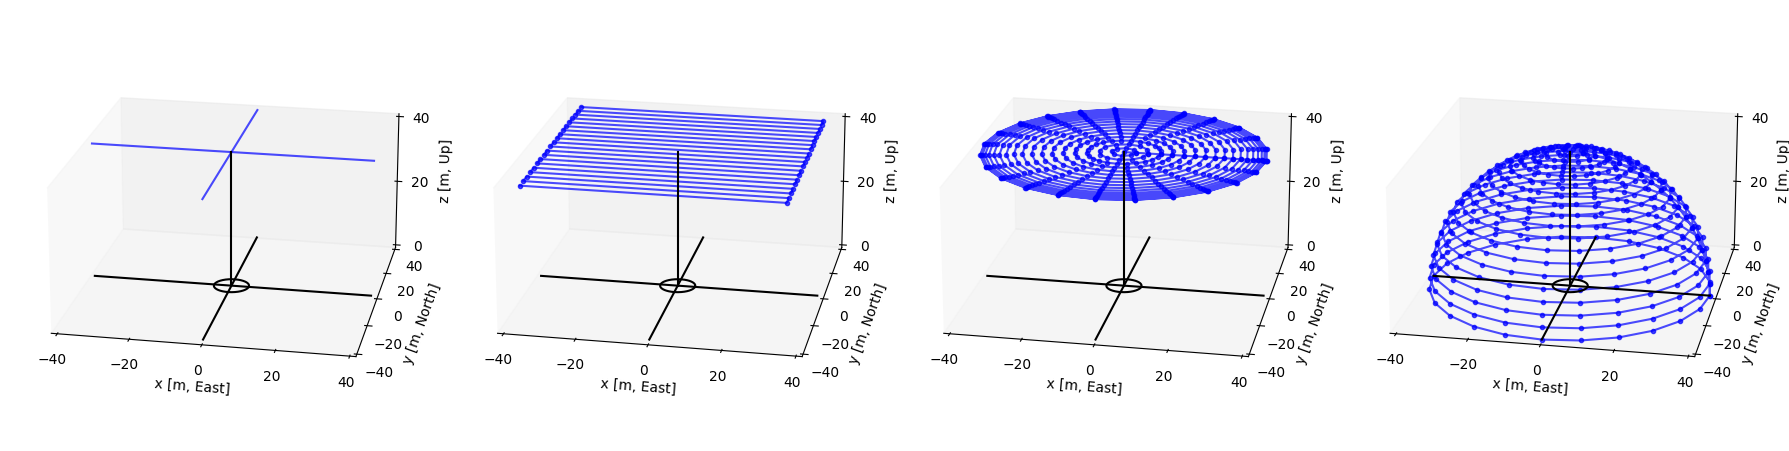

In [229]:
Dish_Diameter=10







## Initialize 3d Figure for Spherical Shell Plot:
fig=figure(figsize=(18,5))
ax3d1=fig.add_subplot(141,projection='3d')    
ax3d2=fig.add_subplot(142,projection='3d')    
ax3d3=fig.add_subplot(143,projection='3d')    
ax3d4=fig.add_subplot(144,projection='3d')   


## Plot waypoints:
Waypoints=Waypoints_Cartesian_Grid(Altitude=40,XAng=42,YAng=42,dX=4,dY=4,Direction='EW',Georef_Error=0.0)
ax3d1.plot(np.zeros(1000),np.linspace(-1.0*fixer,fixer,1000),40*np.ones(1000),'b-',alpha=0.7)
ax3d1.plot(np.linspace(-1.0*fixer,fixer,1000),np.zeros(1000),40*np.ones(1000),'b-',alpha=0.7)
ax3d2.plot(Waypoints[:,0],Waypoints[:,1],40*np.ones(len(Waypoints)),'b.-',alpha=0.7)
Waypoints=Waypoints_Spherical_Shell(Radius=40,Georef_Error=2.0,thetaparams=[0,360,15.0],phiparams=[90,0,5])
ax3d3.plot(Waypoints[:,0],Waypoints[:,1],40*np.ones(len(Waypoints)),'b.-',alpha=0.7)
ax3d4.plot(Waypoints[:,0],Waypoints[:,1],Waypoints[:,2],'b.-',alpha=0.7)
# ax3d4.plot(Waypoints[:,0], Waypoints[:,2], 'b-.',alpha=0.2, zdir='y', zs=fixer)
# ax3d4.plot(Waypoints[:,1], Waypoints[:,2], 'b-.',alpha=0.2, zdir='x', zs=-1.0*fixer)
# ax3d4.plot(Waypoints[:,0], Waypoints[:,1], 'k-.',alpha=0.2, zdir='z', zs=0)

titles=["E-Plane and H-Plane Cuts","2d Cartesian Grid","2d Polar Grid","3d Spherical Shell"]
for i,ax in enumerate([ax3d1,ax3d2,ax3d3,ax3d4]):
    ax.set_xlabel('x [m, East]')
    ax.set_ylabel('y [m, North]')
    ax.set_zlabel('z [m, Up]')
    ax.set_xlim(-1.0*fixer,fixer)
    ax.set_ylim(-1.0*fixer,fixer)
    ax.set_zlim(0,fixer)
    ## Plot Model of Dish:
    ax.plot(0.5*Dish_Diameter*np.cos(np.linspace(0,2*np.pi,1000)),0.5*Dish_Diameter*np.sin(np.linspace(0,2*np.pi,1000)),np.zeros(1000),'k-')
#     ax.plot(0,0,0,'ro',zorder=10)
    ax.grid(False)
    fixer=np.nanmax(Waypoints)
    ax.plot(np.zeros(1000),np.linspace(-1.0*fixer,fixer,1000),np.zeros(1000),'k-')
    ax.plot(np.linspace(-1.0*fixer,fixer,1000),np.zeros(1000),np.zeros(1000),'k-')
    ax.plot(np.zeros(1000),np.zeros(1000),np.linspace(0,fixer,1000),'k-')
#     ax.set_title(titles[i])
    ax.set_box_aspect((1,1,0.5))
    ax.set_xticks([-40,-20,0,20,40])
    ax.set_yticks([-40,-20,0,20,40])
    ax.set_zticks([0,20,40])
    ax.view_init(20, -79) 



fig.tight_layout()

--> Total Waypoints is 3046
  --> For chosen velocity 1.00m/s
  --> Total Flight Distance is 8685.24m
  --> Total Flight time is 8685.24s (144.75min) ==> corresp. 206792 corr samples
--> Number of files is 1 containing 3046 waypoints.
  --> Saving file 0/1: /home/tyndall/Desktop/WLC_sphere_60m_NS_0.csv
--> Number of files is 1 containing 3046 waypoints.
  --> Saving file 0/1: /home/tyndall/Desktop/WLC_sphere_60m_EW_0.csv


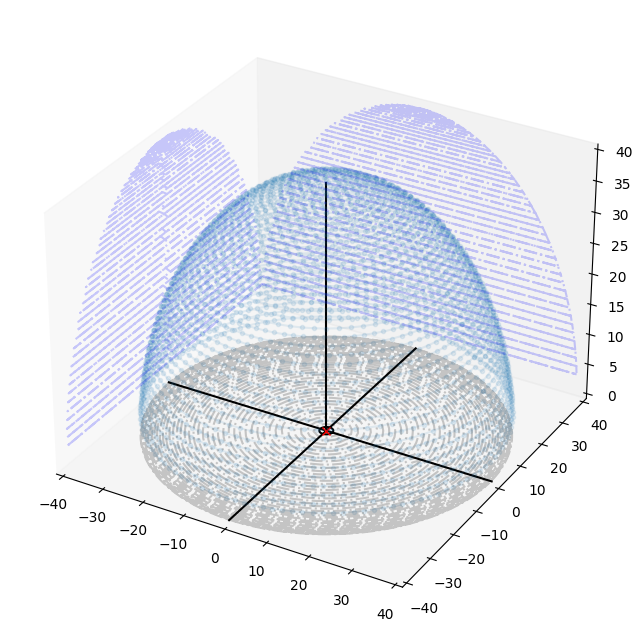

In [6]:
wps=Waypoints_Spherical_Shell(Radius=40,Georef_Error=2.0,thetaparams=[0,360,1.0],phiparams=[90,5,2])
Plot_Spherical_Shell(wps,3.0)

vel=1.0
d_tot=(np.nansum([np.nansum(np.abs(wps[k+1]-wps[k])) for k in range(len(wps)-1)]))
t_tot=d_tot/vel
n_corr=int(np.ceil(t_tot/0.042))
print("--> Total Waypoints is {}".format(len(wps)))
print("  --> For chosen velocity {:.2f}m/s".format(vel))
print("  --> Total Flight Distance is {:.2f}m".format(d_tot))
print("  --> Total Flight time is {:.2f}s ({:.2f}min) ==> corresp. {} corr samples".format(t_tot,t_tot/60.0,n_corr))
    
gridwps=wps
gridvels=1.0*np.ones(len(gridwps))
gridyaws=0.0*np.ones(len(gridwps))
gridwts=0.0*np.ones(len(gridwps))
Generate_UgCS_CSV(Filestring="/home/tyndall/Desktop/WLC_sphere_60m_NS.csv",Center_LatLon=WLC_3m_LatLon,\
                  Waypoints_LC=gridwps,Speeds=gridvels,Yaws=gridyaws,Altitude_Convention="AltitudeAMSL")#,WaitTimes=gridwts)
gridwps=wps
gridvels=1.0*np.ones(len(gridwps))
gridyaws=90.0*np.ones(len(gridwps))
gridwts=0.0*np.ones(len(gridwps))
Generate_UgCS_CSV(Filestring="/home/tyndall/Desktop/WLC_sphere_60m_EW.csv",Center_LatLon=WLC_3m_LatLon,\
                  Waypoints_LC=gridwps,Speeds=gridvels,Yaws=gridyaws,Altitude_Convention="AltitudeAMSL")#,WaitTimes=gridwts)

--> Total Waypoints is 98
  --> For chosen velocity 0.40m/s
  --> Total Flight Distance is 584.91m
  --> Total Flight time is 1462.28s (24.37min) ==> corresp. 34817 corr samples
--> Number of files is 1 containing 98 waypoints.
  --> Saving file 0/1: /home/tyndall/Desktop/WLC_grid_10m_NS_0.csv
--> Number of files is 1 containing 98 waypoints.
  --> Saving file 0/1: /home/tyndall/Desktop/WLC_grid_10m_EW_0.csv


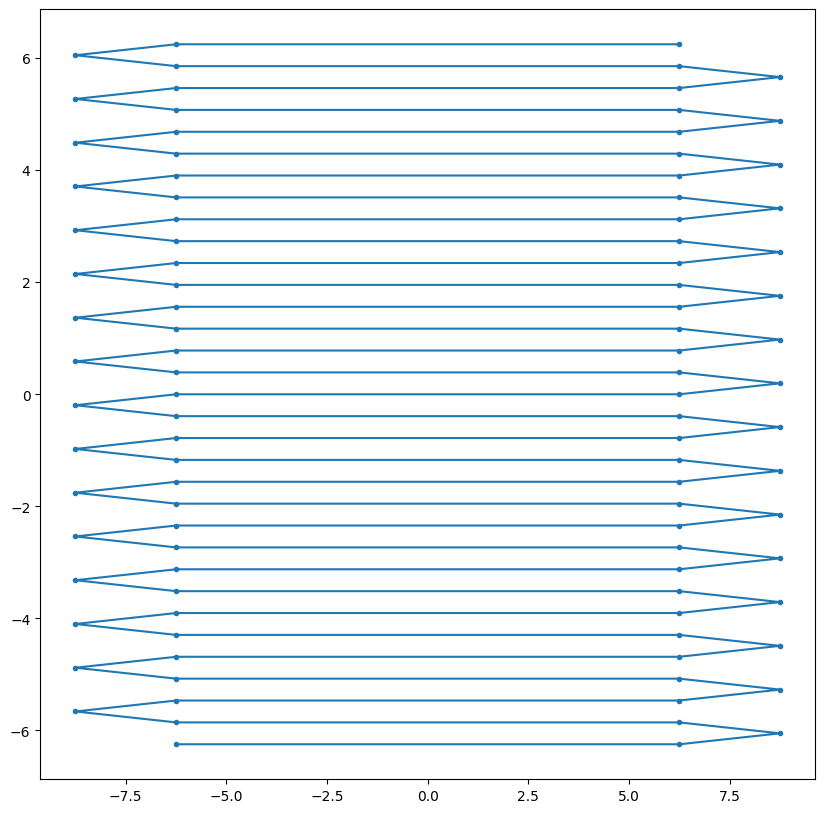

In [7]:
figure(figsize=(10,10))
wps=Waypoints_Cartesian_Grid(Altitude=10,XAng=32,YAng=32,dX=0.4,dY=0.4,Direction='EW',Georef_Error=2.5)
plot(wps[:,0],wps[:,1],'.-')

vel=0.4
d_tot=(np.nansum([np.nansum(np.abs(wps[k+1]-wps[k])) for k in range(len(wps)-1)]))
t_tot=d_tot/vel
n_corr=int(np.ceil(t_tot/0.042))
print("--> Total Waypoints is {}".format(len(wps)))
print("  --> For chosen velocity {:.2f}m/s".format(vel))
print("  --> Total Flight Distance is {:.2f}m".format(d_tot))
print("  --> Total Flight time is {:.2f}s ({:.2f}min) ==> corresp. {} corr samples".format(t_tot,t_tot/60.0,n_corr))
    
gridwps=wps
gridvels=vel*np.ones(len(gridwps))
gridyaws=0.0*np.ones(len(gridwps))
gridwts=0.0*np.ones(len(gridwps))
Generate_UgCS_CSV(Filestring="/home/tyndall/Desktop/WLC_grid_10m_NS.csv",Center_LatLon=WLC_3m_LatLon,\
                  Waypoints_LC=gridwps,Speeds=gridvels,Yaws=gridyaws,Altitude_Convention="AltitudeAMSL")#,WaitTimes=gridwts)
gridwps=wps
gridvels=vel*np.ones(len(gridwps))
gridyaws=90.0*np.ones(len(gridwps))
gridwts=0.0*np.ones(len(gridwps))
Generate_UgCS_CSV(Filestring="/home/tyndall/Desktop/WLC_grid_10m_EW.csv",Center_LatLon=WLC_3m_LatLon,\
                  Waypoints_LC=gridwps,Speeds=gridvels,Yaws=gridyaws,Altitude_Convention="AltitudeAMSL")#,WaitTimes=gridwts)


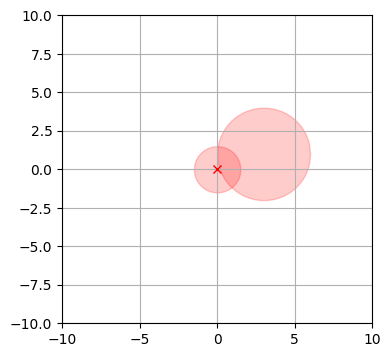

In [8]:
figure(figsize=(4,4))
plot(0,0,'rx')

def fb_circ(D,X0=0.0,Y0=0.0):
    X=np.linspace((-D/2.0)+X0,+(D/2.0)+X0,100)
    YP=np.sqrt(((D/2.0)**2.0)-(X-X0)**2.0)+Y0
    YM=(-1.0*np.sqrt(((D/2.0)**2.0)-((X-X0)**2.0)))+Y0
    return(X,YP,YM)

x,yp,ym=fb_circ(3.0)
fill_between(x,yp,ym,color='r',alpha=0.2)

x,yp,ym=fb_circ(6.0,3.0,1.0)
fill_between(x,yp,ym,color='r',alpha=0.2)

xlim(-10,10)
ylim(-10,10)
grid()

Minimum frequency = 400.00MHz is maximum wavelength = 75.00cm
Maximum frequency = 800.00MHz is minimum wavelength = 37.50cm
Nyquist sampling grid spacing is min(wavelength)/2 = 18.75cm
Frequencies: 721.7986314760508 MHz to 643.5972629521017 MHz
Wavelengths: 41.56283856988083 cm to 46.613001215066824 cm


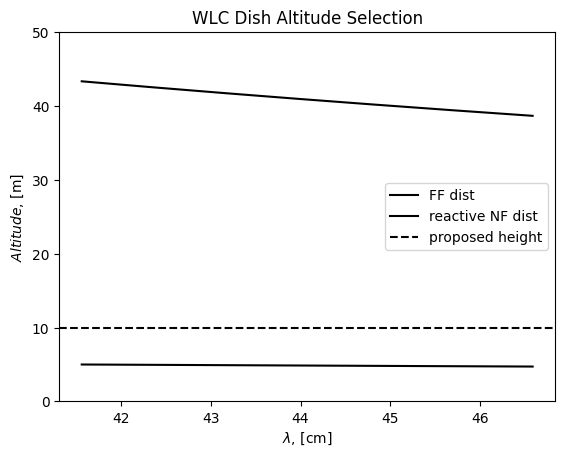

In [9]:
## Specify frequency and wavelength ranges for correlator:
freq=np.linspace(800,400,1024)
wavelength=3e10/(1e6*freq)
D3A_D=300
print("Minimum frequency = {:.2f}MHz is maximum wavelength = {:.2f}cm".format(min(freq),max(wavelength)))
print("Maximum frequency = {:.2f}MHz is minimum wavelength = {:.2f}cm".format(max(freq),min(wavelength)))

## What should the grid spacing look li700,650ke? (lam700,650bda/2 for nyquist sampling...)
print("Nyquist sampling grid spacing is min(wavelength)/2 = {:.2f}cm".format(min(wavelength)/2.0))

## For WLC telescope, beam is only really usable between frequency indices 200 and 400:
print("Frequencies:",freq[200],"MHz to",freq[400],"MHz")
print("Wavelengths:",wavelength[200],"cm to",wavelength[400],"cm")
title("WLC Dish Altitude Selection")
plot(wavelength[200:400],Reactive_NF_Distance_m(300,wavelength[200:400]),'k',label='FF dist')
plot(wavelength[200:400],FF_Distance_m(300,wavelength[200:400]),'k',label='reactive NF dist')
axhline(10,c='k',linestyle='dashed',label='proposed height')
ylim(0,50)
ylabel('$Altitude$, [m]')
xlabel('$\lambda$, [cm]')
legend()

Initializing drone data via Airdata.csv routine: Fly2024020801Airdata.csv
  --> Skipping rows 1 to 1 to eliminate NAN values
  --> generating llh, geocentric cartesian, local cartesian, and local spherical coordinates.
  --> generating dish and receiver line of sight coordinates.
plotting drone coordinates for all time samples:
overplotting drone coordinates for t_cut samples: [0:-1]


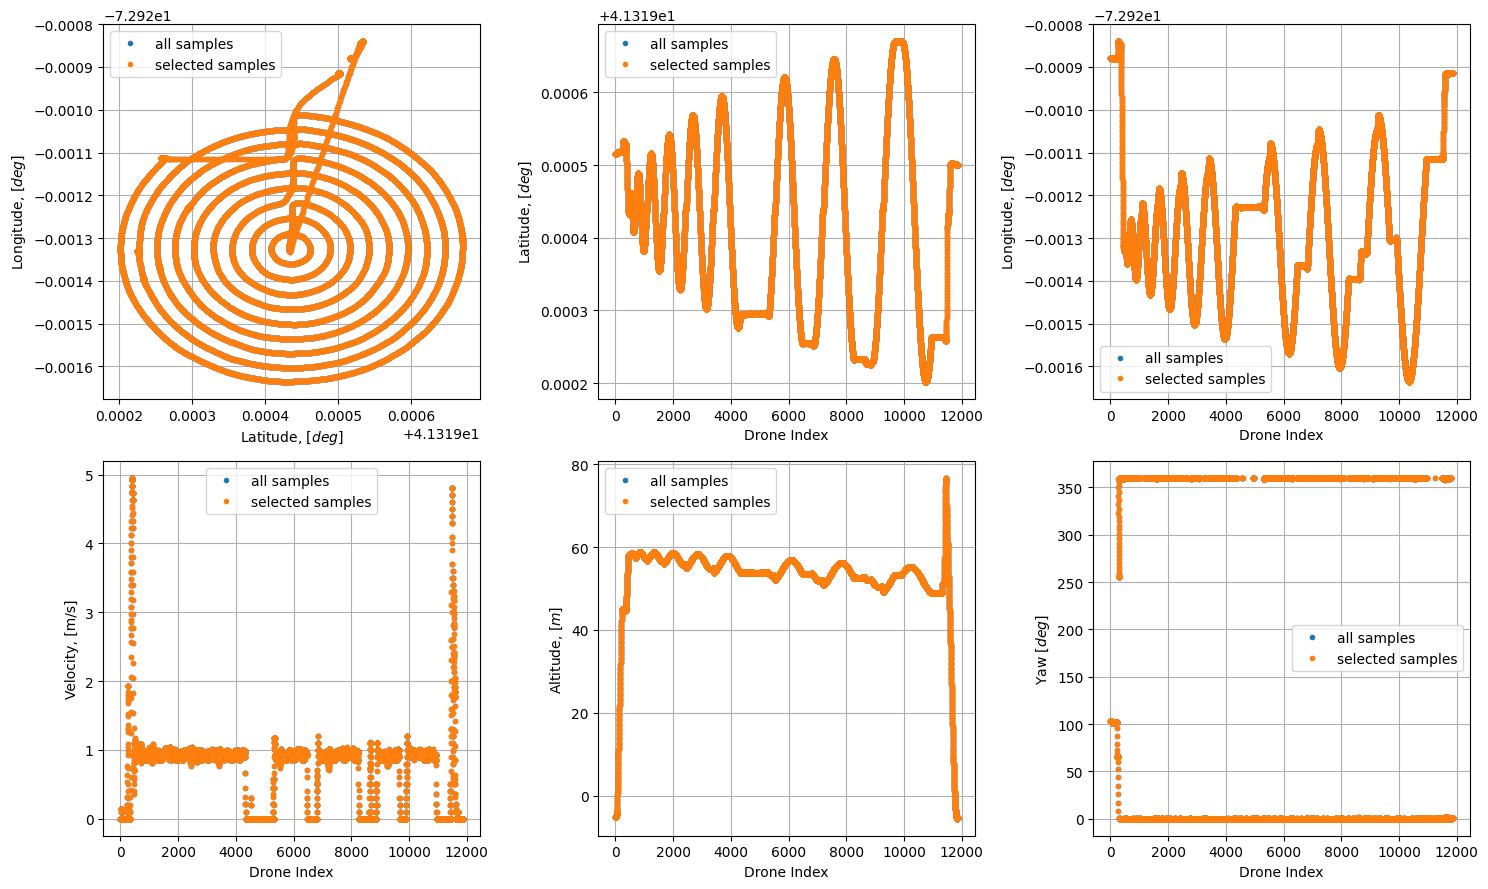

In [10]:
dronedir='/home/tyndall/Desktop/NF2FF/20240208_WLC_NFandFF/'
NFNSdrone=drone.Drone_Data(Drone_Directory=dronedir,FLYTAG='Fly2024020801Airdata.csv',tlb=-498,site_class=wlcsiteNS)
pu.Plot_Drone_Coordinates(NFNSdrone)

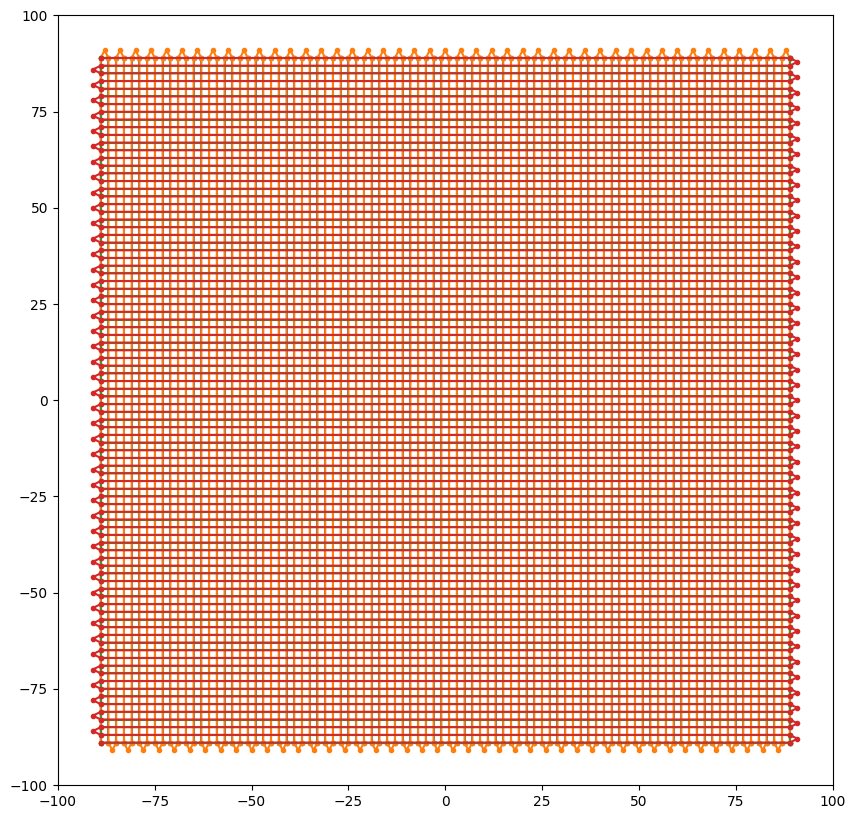

In [11]:
Altitude=106
XAng=40
YAng=40
dX=2
dY=2
XSpan=2*(Altitude*np.tan(XAng*np.pi/180.0))
nX=int(np.ceil(XSpan/dX))+1
Xpts=np.linspace(-0.5*XSpan,+0.5*XSpan,nX)
YSpan=2*(Altitude*np.tan(YAng*np.pi/180.0))
nY=int(np.ceil(YSpan/dY))+1
Ypts=np.linspace(-0.5*YSpan,+0.5*YSpan,nY)

tmp_waypoints=np.zeros((int(2*len(Ypts)),3))
tmp_waypoints[:,0]=np.repeat((Xpts),2)
tmp_waypoints[:,1]=np.tile(np.array([Ypts[0],Ypts[-1],Ypts[-1],Ypts[0]]),int(len(Xpts)))[:int(2*len(Ypts))]
tmp_waypoints[:,2]=Altitude*np.ones(int(2*len(Xpts)))
insert_indices=np.where(np.abs((np.nansum(np.diff(tmp_waypoints,axis=0)**2.0,axis=1)**0.5))<=2.0)[0]
insert_waypoints=np.zeros((len(insert_indices),3))
final_waypoints=np.zeros((len(insert_indices)+len(tmp_waypoints),3))
for k,i in enumerate(insert_indices):
    insert_waypoints[k,:]=(((tmp_waypoints[i]+tmp_waypoints[i+1])/2.0)+np.array([0,np.sign(tmp_waypoints[i,1])*2.0,0]))
j=0
for i in np.arange(len(tmp_waypoints)):
    if i in insert_indices:
        final_waypoints[j+i,:]=tmp_waypoints[i,:]
        final_waypoints[j+i+1,:]=insert_waypoints[j,:]
        j=j+1
    else:
        final_waypoints[j+i,:]=tmp_waypoints[i,:]

figure(figsize=(10,10))
plot(tmp_waypoints[:,0],tmp_waypoints[:,1],'.-')
plot(final_waypoints[:,0],final_waypoints[:,1],'.-')


tmp_waypoints=np.zeros((int(2*len(Xpts)),3))
tmp_waypoints[:,0]=np.tile(np.array([Xpts[0],Xpts[-1],Xpts[-1],Xpts[0]]),int(len(Ypts)))[:int(2*len(Xpts))]
tmp_waypoints[:,1]=np.repeat((Ypts),2)
tmp_waypoints[:,2]=Altitude*np.ones(int(2*len(Xpts)))
insert_indices=np.where(np.abs((np.nansum(np.diff(tmp_waypoints,axis=0)**2.0,axis=1)**0.5))<=2.0)[0]
insert_waypoints=np.zeros((len(insert_indices),3))
final_waypoints=np.zeros((len(insert_indices)+len(tmp_waypoints),3))
for k,i in enumerate(insert_indices):
    insert_waypoints[k,:]=(((tmp_waypoints[i]+tmp_waypoints[i+1])/2.0)+np.array([np.sign(tmp_waypoints[i,0])*2.0,0,0]))
j=0
for i in np.arange(len(tmp_waypoints)):
    if i in insert_indices:
        final_waypoints[j+i,:]=tmp_waypoints[i,:]
        final_waypoints[j+i+1,:]=insert_waypoints[j,:]
        j=j+1
    else:
        final_waypoints[j+i,:]=tmp_waypoints[i,:]

# figure(figsize=(10,10))
plot(tmp_waypoints[:,0],tmp_waypoints[:,1],'.-')
plot(final_waypoints[:,0],final_waypoints[:,1],'.-')


In [12]:
def Waypoints_Cartesian_Grid(Altitude,XAng,YAng,dX,dY,Direction='EW',Georef_Error=2.0):
    XSpan=2*(Altitude*np.tan(XAng*np.pi/180.0))
    nX=int(np.ceil(XSpan/dX))+1
    Xpts=np.linspace(-0.5*XSpan,+0.5*XSpan,nX)
    YSpan=2*(Altitude*np.tan(YAng*np.pi/180.0))
    nY=int(np.ceil(YSpan/dY))+1
    Ypts=np.linspace(-0.5*YSpan,+0.5*YSpan,nY)
    x_grid,y_grid=np.meshgrid(Xpts,Ypts)
    if Direction=='EW':  
        tmp_waypoints=np.zeros((int(2*len(Ypts)),3))
        tmp_waypoints[:,0]=np.repeat((Xpts),2)
        tmp_waypoints[:,1]=np.tile(np.array([Ypts[0],Ypts[-1],Ypts[-1],Ypts[0]]),int(len(Xpts)))[:int(2*len(Ypts))]
        tmp_waypoints[:,2]=Altitude*np.ones(int(2*len(Xpts)))
        insert_indices=np.where(np.abs((np.nansum(np.diff(tmp_waypoints,axis=0)**2.0,axis=1)**0.5))<=Georef_Error)[0]
        insert_waypoints=np.zeros((len(insert_indices),3))
        final_waypoints=np.zeros((len(insert_indices)+len(tmp_waypoints),3))
        for k,i in enumerate(insert_indices):
            insert_waypoints[k,:]=(((tmp_waypoints[i]+tmp_waypoints[i+1])/2.0)+np.array([0,np.sign(tmp_waypoints[i,1])*2.0,0]))
        j=0
        for i in np.arange(len(tmp_waypoints)):
            if i in insert_indices:
                final_waypoints[j+i,:]=tmp_waypoints[i,:]
                final_waypoints[j+i+1,:]=insert_waypoints[j,:]
                j=j+1
            else:
                final_waypoints[j+i,:]=tmp_waypoints[i,:]
    elif Direction=='NS':
        tmp_waypoints=np.zeros((int(2*len(Xpts)),3))
        tmp_waypoints[:,0]=np.tile(np.array([Xpts[0],Xpts[-1],Xpts[-1],Xpts[0]]),int(len(Ypts)))[:int(2*len(Xpts))]
        tmp_waypoints[:,1]=np.repeat((Ypts),2)
        tmp_waypoints[:,2]=Altitude*np.ones(int(2*len(Xpts)))
        insert_indices=np.where(np.abs((np.nansum(np.diff(tmp_waypoints,axis=0)**2.0,axis=1)**0.5))<=Georef_Error)[0]
        insert_waypoints=np.zeros((len(insert_indices),3))
        final_waypoints=np.zeros((len(insert_indices)+len(tmp_waypoints),3))
        for k,i in enumerate(insert_indices):
            insert_waypoints[k,:]=(((tmp_waypoints[i]+tmp_waypoints[i+1])/2.0)+np.array([np.sign(tmp_waypoints[i,0])*2.0,0,0]))
        j=0
        for i in np.arange(len(tmp_waypoints)):
            if i in insert_indices:
                final_waypoints[j+i,:]=tmp_waypoints[i,:]
                final_waypoints[j+i+1,:]=insert_waypoints[j,:]
                j=j+1
            else:
                final_waypoints[j+i,:]=tmp_waypoints[i,:]
    return final_waypoints

In [13]:
Waypoints_Cartesian_Grid(Altitude=100,XAng=50,YAng=50,dX=0.5,dY=0.5,Direction='EW',Georef_Error=2.0)

array([[-119.17535926, -119.17535926,  100.        ],
       [-119.17535926,  119.17535926,  100.        ],
       [-118.92551574,  121.17535926,  100.        ],
       ...,
       [ 118.92551574,  121.17535926,  100.        ],
       [ 119.17535926,  119.17535926,  100.        ],
       [ 119.17535926, -119.17535926,  100.        ]])

--> Total Waypoints is 140
  --> For chosen velocity 0.40m/s
  --> Total Flight Distance is 994.29m
  --> Total Flight time is 2485.74s (41.43min) ==> corresp. 59185 corr samples
--> With 200ms pulsing, the largest gap can be 6 samples wide ==> 0.003cm
--> Number of files is 1 containing 140 waypoints.
  --> WARNING: 69 waypoints do not meet 0.5m spacing.
  --> Saving file 0/1: /home/tyndall/Desktop/WLC_grid_10m_NS_0.csv
--> Number of files is 1 containing 140 waypoints.
  --> WARNING: 69 waypoints do not meet 0.5m spacing.
  --> Saving file 0/1: /home/tyndall/Desktop/WLC_grid_10m_EW_0.csv


array([14.00415076,  0.20295871, 14.00415076,  0.20295871, 14.00415076,
        0.20295871, 14.00415076,  0.20295871, 14.00415076,  0.20295871,
       14.00415076,  0.20295871, 14.00415076,  0.20295871, 14.00415076,
        0.20295871, 14.00415076,  0.20295871, 14.00415076,  0.20295871,
       14.00415076,  0.20295871, 14.00415076,  0.20295871, 14.00415076,
        0.20295871, 14.00415076,  0.20295871, 14.00415076,  0.20295871,
       14.00415076,  0.20295871, 14.00415076,  0.20295871, 14.00415076,
        0.20295871, 14.00415076,  0.20295871, 14.00415076,  0.20295871,
       14.00415076,  0.20295871, 14.00415076,  0.20295871, 14.00415076,
        0.20295871, 14.00415076,  0.20295871, 14.00415076,  0.20295871,
       14.00415076,  0.20295871, 14.00415076,  0.20295871, 14.00415076,
        0.20295871, 14.00415076,  0.20295871, 14.00415076,  0.20295871,
       14.00415076,  0.20295871, 14.00415076,  0.20295871, 14.00415076,
        0.20295871, 14.00415076,  0.20295871, 14.00415076,  0.20

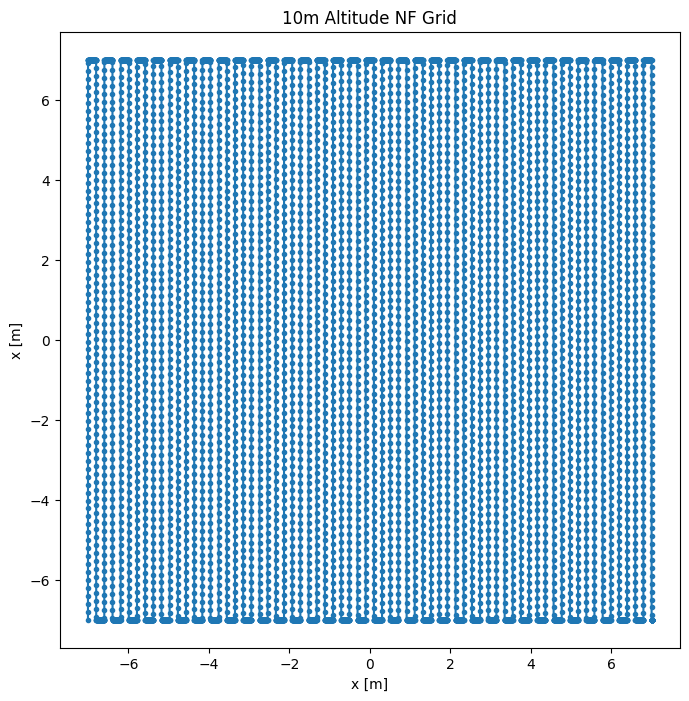

<Figure size 640x480 with 0 Axes>

In [16]:
fig=figure(figsize=(8,8))
wps=Waypoints_Cartesian_Grid(10.0,35,35,.205,.205,Direction='EW',Georef_Error=0.0)
title("10m Altitude NF Grid")
xlabel("x [m]")
ylabel("x [m]")

vel=0.4
d_tot=(np.nansum([np.nansum(np.abs(wps[k+1]-wps[k])) for k in range(len(wps)-1)]))
t_tot=d_tot/vel
n_corr=int(np.ceil(t_tot/0.042))
print("--> Total Waypoints is {}".format(len(wps)))
print("  --> For chosen velocity {:.2f}m/s".format(vel))
print("  --> Total Flight Distance is {:.2f}m".format(d_tot))
print("  --> Total Flight time is {:.2f}s ({:.2f}min) ==> corresp. {} corr samples".format(t_tot,t_tot/60.0,n_corr))

xinterp=np.interp(np.linspace(0,len(wps),n_corr),np.arange(len(wps[:,0])),wps[:,0])
yinterp=np.interp(np.linspace(0,len(wps),n_corr),np.arange(len(wps[:,1])),wps[:,1])
plot(xinterp[::6],yinterp[::6],'.-')

print("--> With 200ms pulsing, the largest gap can be 6 samples wide ==> {:.3f}cm".format(np.nanmax(np.diff(xinterp[::6]))))
    
gridwps=wps
gridvels=0.4*np.ones(len(gridwps))
gridyaws=0.0*np.ones(len(gridwps))
gridwts=0.0*np.ones(len(gridwps))
Generate_UgCS_CSV(Filestring="/home/tyndall/Desktop/WLC_grid_10m_NS.csv",Center_LatLon=WLC_3m_LatLon,\
                  Waypoints_LC=gridwps,Speeds=gridvels,Yaws=gridyaws)#,WaitTimes=gridwts)

gridwps=wps
gridvels=0.4*np.ones(len(gridwps))
gridyaws=90.0*np.ones(len(gridwps))
gridwts=0.0*np.ones(len(gridwps))
Generate_UgCS_CSV(Filestring="/home/tyndall/Desktop/WLC_grid_10m_EW.csv",Center_LatLon=WLC_3m_LatLon,\
                  Waypoints_LC=gridwps,Speeds=gridvels,Yaws=gridyaws)#,WaitTimes=gridwts)

figure()
np.sqrt(np.nansum((np.diff(wps,axis=0)**2.0),axis=1))

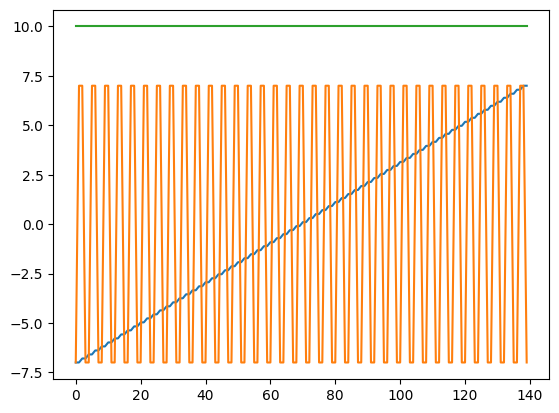

In [17]:
plot(wps[:,0])
plot(wps[:,1])
plot(wps[:,2])

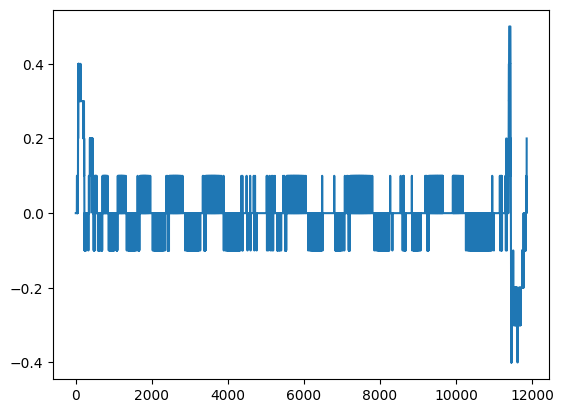

In [18]:
plot(np.diff(NFNSdrone.altitude))

[5.260874452027913, 48.0]
[3.7199999999999998, 24.0]
Maximum Radiating NF = 5.26m
Minimum FF Altitude = 24.00m


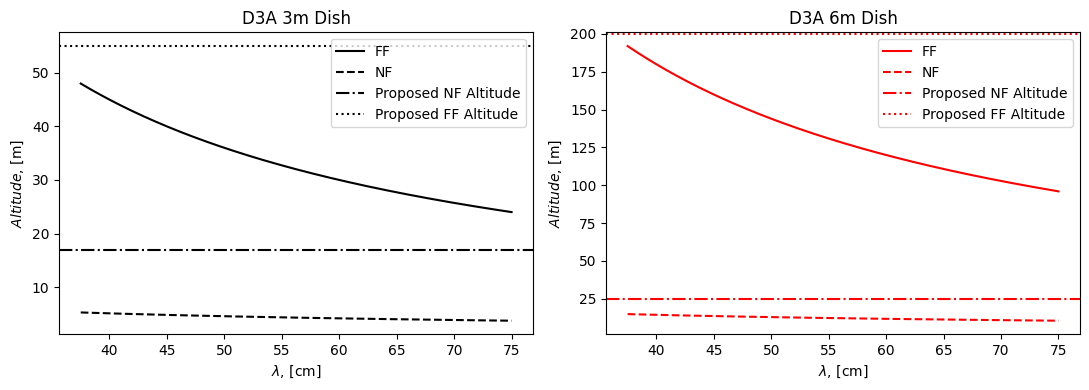

In [51]:
## What altitude should we do the flight at to be in the radiating nearfield?
print(Radiative_NF_Bounds_m(D3A_D,min(wavelength)))
print(Radiative_NF_Bounds_m(D3A_D,max(wavelength)))
print("Maximum Radiating NF = {:.2f}m".format(Reactive_NF_Distance_m(D3A_D,min(wavelength))))
print("Minimum FF Altitude = {:.2f}m".format(FF_Distance_m(D3A_D,max(wavelength))))

fig,[ax1,ax2]=subplots(nrows=1,ncols=2,figsize=(11,4))
ax1.set_title('D3A 3m Dish')
ax1.plot(wavelength,FF_Distance_m(300,wavelength),'k-',label='FF')
ax1.plot(wavelength,Reactive_NF_Distance_m(300,wavelength),'k--',label='NF')
ax1.axhline(17,color='k',linestyle='-.',label='Proposed NF Altitude')
ax1.axhline(55,color='k',linestyle=':',label='Proposed FF Altitude')
ax2.set_title('D3A 6m Dish')
ax2.plot(wavelength,FF_Distance_m(600,wavelength),'r-',label='FF')
ax2.plot(wavelength,Reactive_NF_Distance_m(600,wavelength),'r--',label='NF')
ax2.axhline(25,color='r',linestyle='-.',label='Proposed NF Altitude')
ax2.axhline(200,color='r',linestyle=':',label='Proposed FF Altitude')
for ax in [ax1,ax2]:
    ax.set_ylabel('$Altitude$, [m]')
    ax.set_xlabel('$\lambda$, [cm]')
    ax.legend()
tight_layout()

delX=0.25 #0.2143 #m
delY=0.25 #0.2143 #m
delT=0.042 #sec
grid_alt=200 #25.0
# I will suggest ~17.0m and 25m for NF grids and 55 and 200m for FF grids...

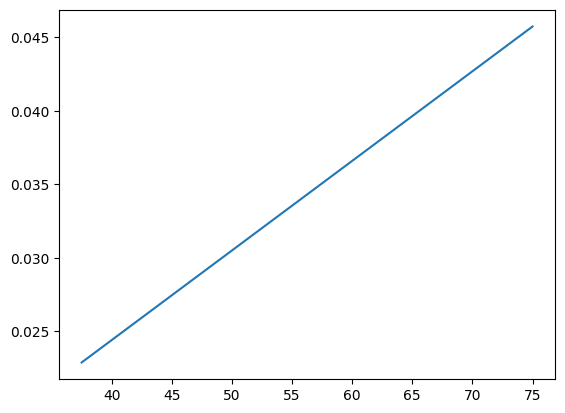

In [52]:
plot(wavelength,1.22*wavelength/2000)
# xlim(75,40)

In [20]:
## If we want to measure E field components for points +30deg to -30deg from zenith at 25m,
## Then our grid would have sides of length 28.86m to measure one dish centered at (0,0)...
grid_sidelength=2*(grid_alt*np.tan(np.pi/180.0*30.0))
print("For a {}m alt grid that spans [+30.0,-30.0] deg, sides must be {:.2f}m".format(grid_alt,grid_sidelength))
## How many points will a pass contain if sampled at nyquist freq?
grid_pts_per_pass=int(np.ceil(grid_sidelength/delX))
print("If sampled at nyquist [{}m] each pass will contain {} points".format(delX,grid_pts_per_pass))
## How many points would the grid contain?
grid_num_pts=grid_pts_per_pass**2
print("The grid would then contain {} points".format((grid_num_pts)))
## How long would a flig,600])ht take?
grid_flight_time=grid_num_pts*delT/60
print("The flight would take approximately {:.2f} minutes".format(grid_flight_time))
## How fast should the drone fly?
grid_flight_speed=(delX/delT)
print("If sampled at nyquist [{}m] the drone can fly at {:.2f}m/s".format(delX,grid_flight_speed))

For a 200m alt grid that spans [+30.0,-30.0] deg, sides must be 230.94m
If sampled at nyquist [0.25m] each pass will contain 924 points
The grid would then contain 853776 points
The flight would take approximately 597.64 minutes
If sampled at nyquist [0.25m] the drone can fly at 5.95m/s


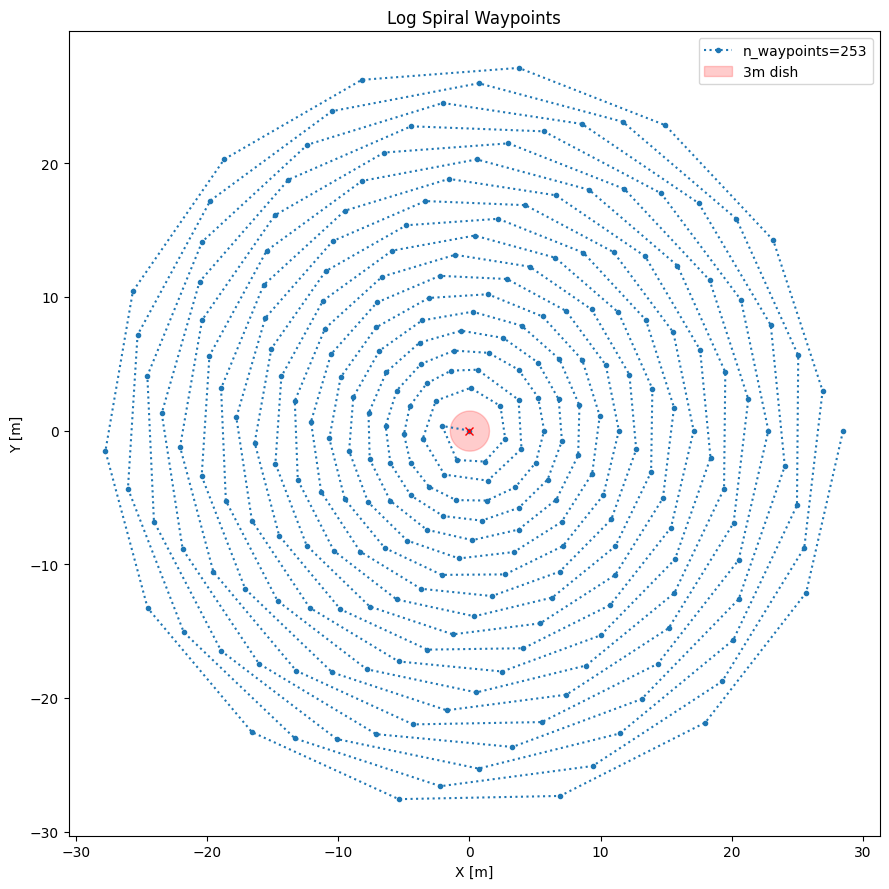

In [21]:
xxx,yyy,maggy,ress=Waypoints_Spiral(Altitude=17,RAng=40,dR=.1,n_wraps=20)
figure,ax1=subplots(nrows=1,ncols=1,figsize=(9,9))
#ax1.plot(maggy,'.:')
ax1.plot(xxx,yyy,'.:',label="n_waypoints={}".format(len(xxx)))
ax1.plot(0,0,'rx')
x,yp,ym=fb_circ(3.0)
fill_between(x,yp,ym,color='r',alpha=0.2,label="3m dish")
legend()
title("Log Spiral Waypoints")
xlabel('X [m]')
ylabel('Y [m]')

#xlim(-10,10)
#ylim(-10,10)

tight_layout()
    


In [23]:
## Importing the AirData .csv file to compare its data columns to our class data requirements:
dat=pandas.read_csv('../../Desktop/NF2FF/20240208_WLC_NFandFF/Fly2024020801Airdata.csv',low_memory=False)

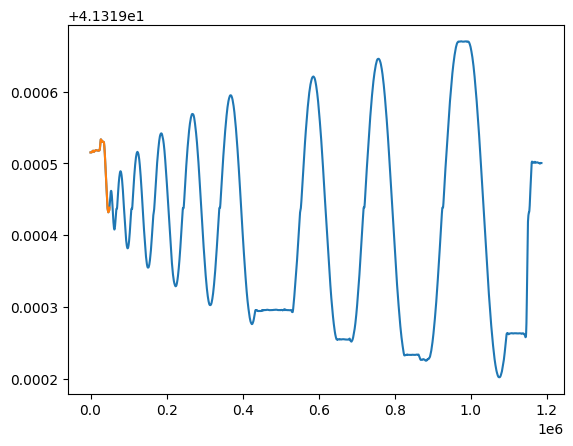

In [24]:
plot(dat['time(millisecond)'],dat['latitude'])
plot(dat['time(millisecond)'][:500],dat['latitude'][:500])

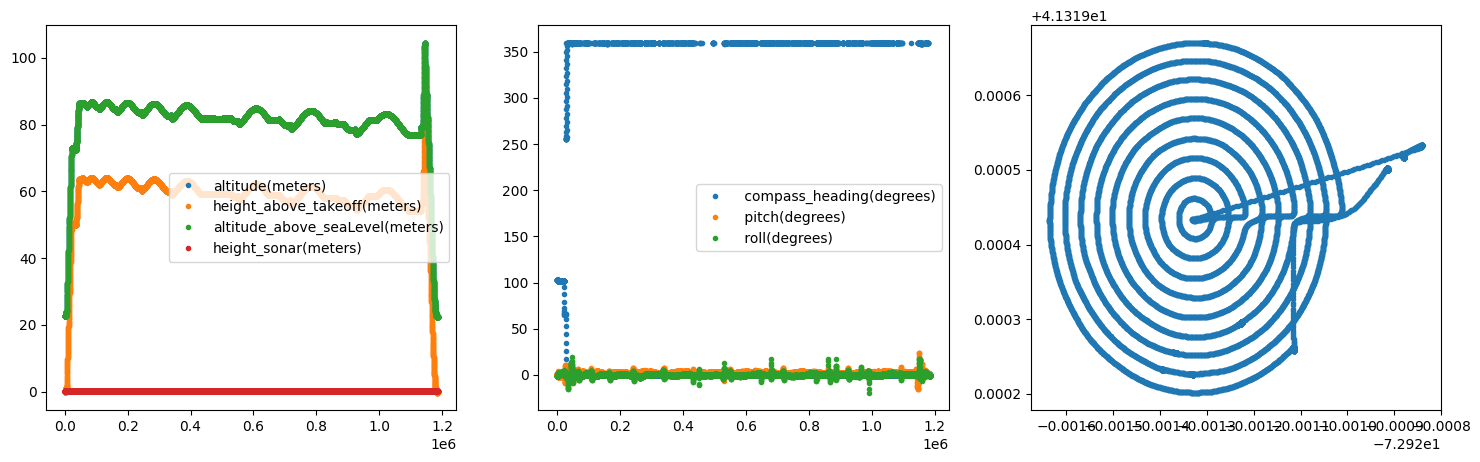

In [25]:
fig,[ax1,ax2,ax3]=subplots(nrows=1,ncols=3,figsize=(18,5))

for vari in ['altitude(meters)','height_above_takeoff(meters)',\
             #'height_above_ground_at_drone_location(meters)',\
             #'ground_elevation_at_drone_location(meters)',\
             'altitude_above_seaLevel(meters)',\
             'height_sonar(meters)']:
    try:
        ax1.plot(np.array(dat['time(millisecond)']),np.array(dat[vari]),'.',label=vari)
    except TypeError:
        print(vari,dat[vari][0])
ax1.legend()

for vari in [' compass_heading(degrees)',' pitch(degrees)',' roll(degrees)']:
    ax2.plot(np.array(dat['time(millisecond)']),np.array(dat[vari]),'.',label=vari)
ax2.legend()
    
ax3.plot(np.array(dat['longitude']),np.array(dat['latitude']),'.')


    

--> Number of files is 1 containing 212 waypoints.
  --> WARNING: 105 waypoints do not meet 0.5m spacing.
  --> Saving file 0/1: /home/tyndall/Desktop/testgrid_0.csv


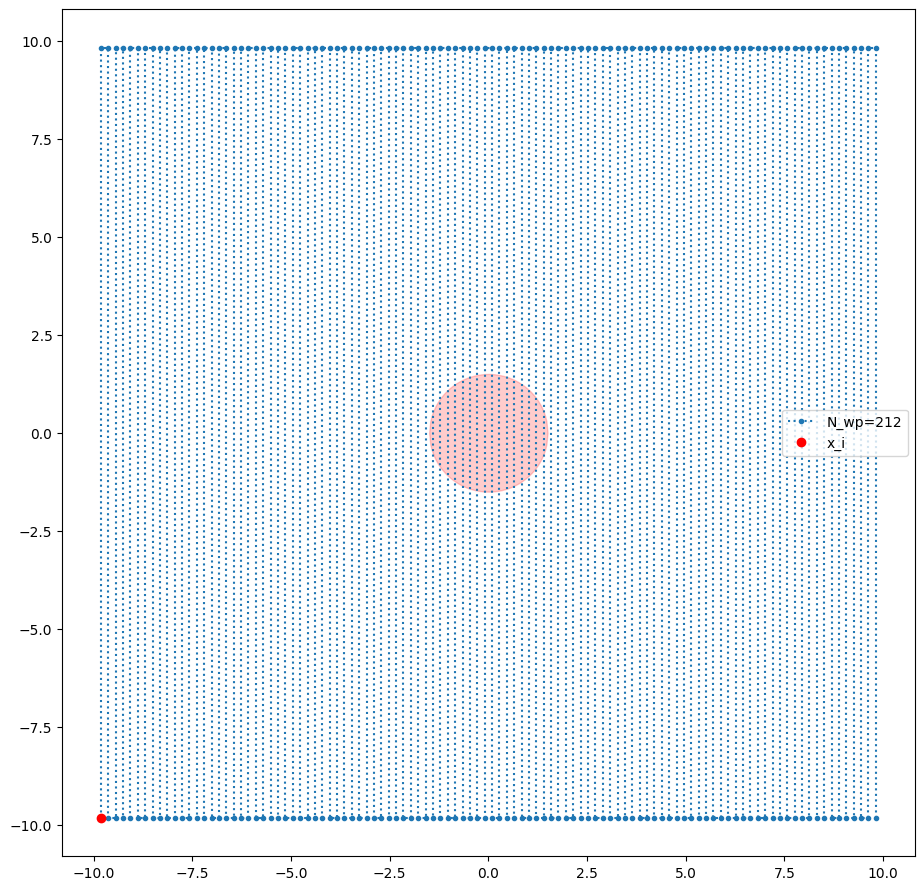

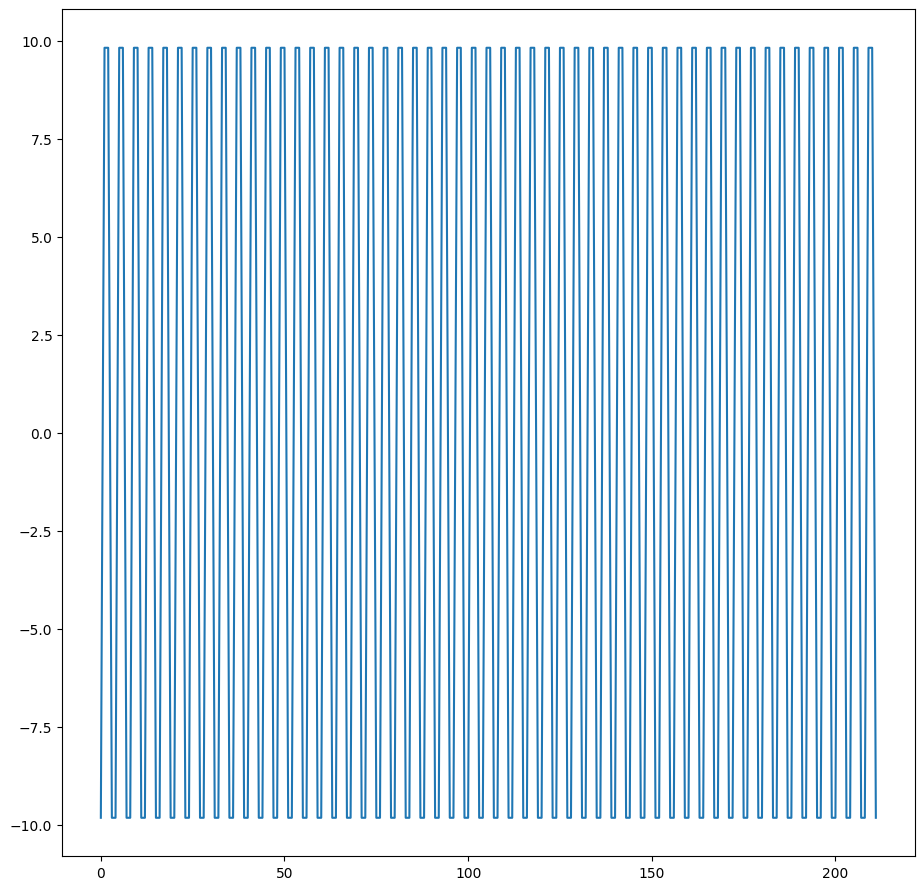

In [26]:
fig,ax=subplots(nrows=1,ncols=1,figsize=(11,11))
xyzp=Waypoints_Cartesian_Grid(17,30,30,0.1875,0.1875,Direction='EW',Georef_Error=0.0)
x,yp,ym=fb_circ(3.0)
fill_between(x,yp,ym,color='r',alpha=0.2)
plot(xyzp[:,0],xyzp[:,1],'.:',label="N_wp={}".format(len(xyzp)))
plot(xyzp[0,0],xyzp[0,1],'ro',label="x_i")
legend()

fig,ax=subplots(nrows=1,ncols=1,figsize=(11,11))
plot(xyzp[:,1])

gridwps=xyzp
gridvels=3.0*np.ones(len(gridwps))
gridyaws=0.0*np.ones(len(gridwps))
gridwts=0.0*np.ones(len(gridwps))
Generate_UgCS_CSV(Filestring="/home/tyndall/Desktop/testgrid.csv",Waypoints_LC=gridwps,\
                  Speeds=gridvels,Yaws=gridyaws,WaitTimes=gridwts)

    

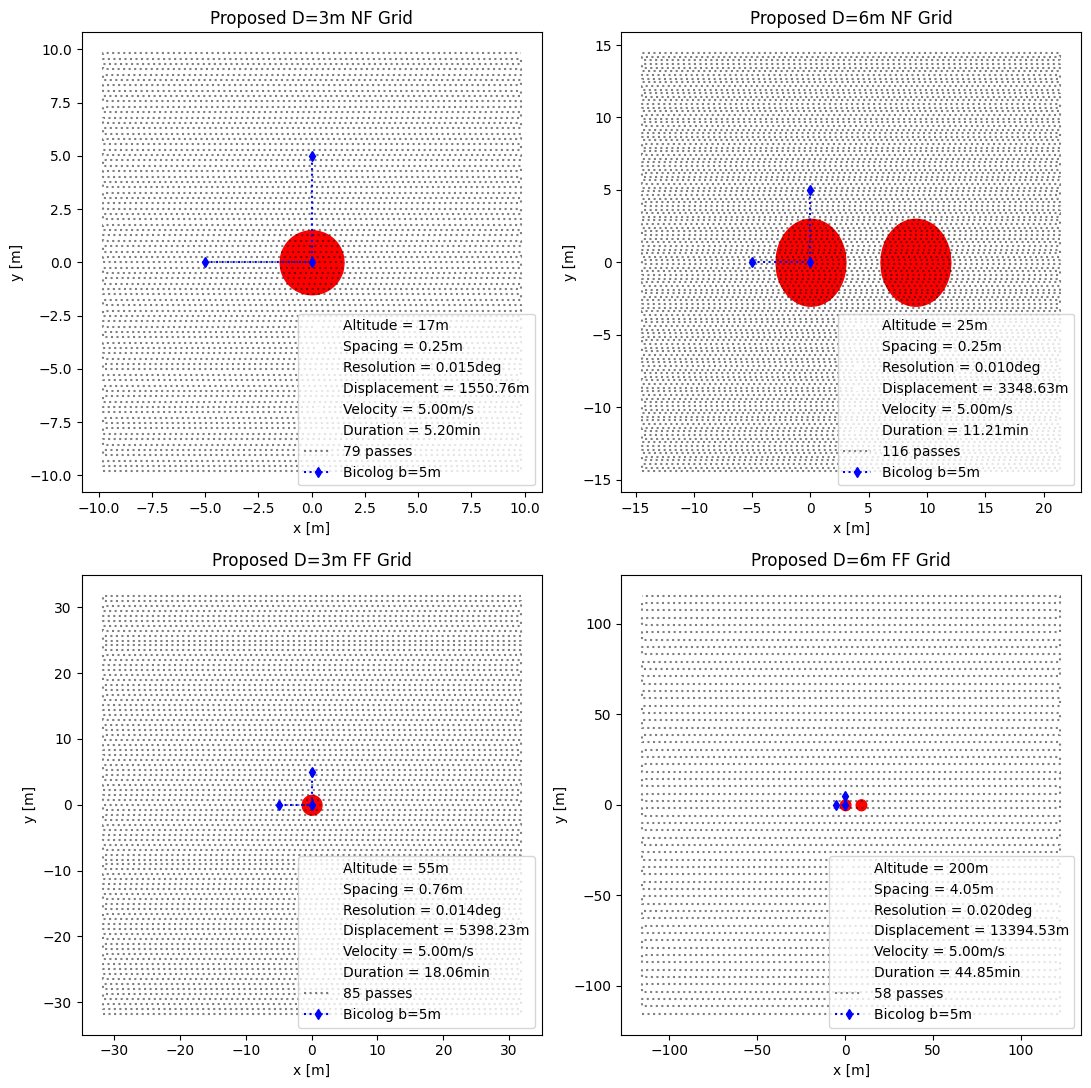

In [27]:
fig,[[ax1,ax2],[ax3,ax4]]=subplots(nrows=2,ncols=2,figsize=(11,11))
grid_corners=np.zeros((4,4,2))#[NF3m,FF3m,NF6m,FF6m]x[NE,SE,SW,NW]x[x,y]

gridh=[0,0,0,0]
gridxl=[0,0,0,0]
gridyl=[0,0,0,0]

alts=[[17,55],[25,200]]
delts=[[0.25,0.75],[0.25,4.0]]
for ax in [ax1,ax3]:
    x,yp,ym=fb_circ(3.0)
    ax.fill_between(x,yp,ym,color='r',alpha=1)
for ax in [ax2,ax4]:
    x,yp,ym=fb_circ(6.0)
    ax.fill_between(x,yp,ym,color='r',alpha=1)
    x,yp,ym=fb_circ(6.0,9.0)
    ax.fill_between(x,yp,ym,color='r',alpha=1)
for i,axes in enumerate([[ax1,ax3],[ax2,ax4]]):
    delT=0.042
    for j,ax in enumerate(axes):
        grid_alt=alts[i][j] #17
        delX=delts[i][j]
        delY=delts[i][j]
        grid_sidelength=2*(grid_alt*np.tan(np.pi/180.0*30.0))
        grid_pts_per_pass=int(np.ceil(grid_sidelength/delX))
        grid_num_pts=grid_pts_per_pass**2
        grid_flight_speed=np.min([5.0,(delX/delT)])
        grid_flight_time=grid_num_pts*delX/grid_flight_speed/60
        dd=np.linspace(-0.5*grid_sidelength,0.5*grid_sidelength,int(np.sqrt(grid_num_pts)))
        griddx=np.zeros((int(np.sqrt(grid_num_pts)),2))
        griddy=np.zeros((int(np.sqrt(grid_num_pts)),2))
        for b,k in enumerate(dd):
            if i==0:
                if b%2==0:
                    griddx[b,:]=np.linspace(-0.5*grid_sidelength,0.5*grid_sidelength,2)
                    griddy[b,:]=k*np.ones(2)
                if b%2==1:
                    griddx[b,:]=np.linspace(-0.5*grid_sidelength,0.5*grid_sidelength,2)[::-1]
                    griddy[b,:]=k*np.ones(2)
            if i==1:
                if b%2==0:
                    griddx[b,:]=np.linspace(-0.5*grid_sidelength,0.5*grid_sidelength+7.0,2)[:10]
                    griddy[b,:]=k*np.ones(2)
                if b%2==1:
                    griddx[b,:]=np.linspace(-0.5*grid_sidelength,0.5*grid_sidelength+7.0,2)[::-1]
                    griddy[b,:]=k*np.ones(2)
        ax.plot([],[],'w.',label="Altitude = {}m".format(grid_alt))
        ax.plot([],[],'w.',label="Spacing = {:.2f}m".format(np.nanmean(np.diff(dd))))
        ax.plot([],[],'w.',label="Resolution = {:.3f}deg".format(delX/grid_alt))
        ax.plot([],[],'w.',label="Displacement = {:.2f}m".format(grid_sidelength*int(np.sqrt(grid_num_pts))))
        ax.plot([],[],'w.',label="Velocity = {:.2f}m/s".format(grid_flight_speed))
        ax.plot([],[],'w.',label="Duration = {:.2f}min".format(grid_flight_time))
        labstr="{} passes".format(int(np.sqrt(grid_num_pts)))
        ax.plot(griddx.flatten(),griddy.flatten(),':',markersize=0.75,color='k',alpha=0.5,label=labstr)
        ax.plot([-5,0,0],[0,0,5],'bd:',markersize=5,label='Bicolog b=5m')
        ax.legend(loc=4)
        ax.set_box_aspect(1)
        ax.set_xlabel("x [m]")
        ax.set_ylabel("y [m]")
        ax.set_title("Proposed D={}m {} Grid".format(["3","6"][i],["NF","FF"][j]))
        grid_corners[int(2*i)+j][0][:]=np.nanmax(griddx),np.nanmax(griddy)
        grid_corners[int(2*i)+j][1][:]=np.nanmax(griddx),np.nanmin(griddy)
        grid_corners[int(2*i)+j][2][:]=np.nanmin(griddx),np.nanmin(griddy)
        grid_corners[int(2*i)+j][3][:]=np.nanmin(griddx),np.nanmax(griddy)
        gridh[int(2*i)+j]=grid_alt
        gridxl[int(2*i)+j]=griddx.flatten()
        gridyl[int(2*i)+j]=griddy.flatten()
tight_layout()

In [29]:
D3A_3m_LatLon=pygeodesy.ellipsoidalNvector.LatLon(49.3220300, -119.6226600, 545.2)
delta=pygeodesy.Ned(50,0,0)
#print(D3A_3m_LatLon.to3llh())
#print(D3A_3m_LatLon.destinationNed(delta).to3llh())

import csv
gridkeys=["NF3m_45d_5mps","FF3m_45d_5mps","NF6m","FF6m"]

for i in range(2):
    dx=gridxl[i]
    dy=gridyl[i]
    h=gridh[i]*np.ones(len(gridxl[i]))
    v=5.0*np.ones(len(gridxl[i]))
    yaw=45.0*np.ones(len(gridxl[i]))
    with open("../../Desktop/Newburgh/flightplans/{}_grid.csv".format(gridkeys[i]),'w') as csvfile:
        print("Latitude,Longitude,AltitudeAGL,Speed,UavYaw",file=csvfile)
        print(f"49.3220258,-119.6227856,0.0,0.0,0.0",file=csvfile)
        for j in range(len(gridxl[i])):
            xx,yy,zz=D3A_3m_LatLon.destinationNed(pygeodesy.Ned(dy[j],dx[j],0.0)).to3llh()
            print("{},{},{},{},{}".format(xx,yy,zz-545.2+h[j],v[j],yaw[j]),file=csvfile)

In [30]:
gridwps=np.array([np.array([gridxl[0][j],gridyl[0][j],gridh[0]]) for j in range(len(gridxl[0]))])
gridvels=3.0*np.ones(len(gridwps))
gridyaws=0.0*np.ones(len(gridwps))
gridwts=0.0*np.ones(len(gridwps))
Generate_UgCS_CSV(Filestring="/home/tyndall/Desktop/testgrid.csv",Waypoints_LC=gridwps,\
                  Speeds=gridvels,Yaws=gridyaws,WaitTimes=gridwts)

--> Number of files is 1 containing 158 waypoints.
  --> WARNING: 78 waypoints do not meet 0.5m spacing.
  --> Saving file 0/1: /home/tyndall/Desktop/testgrid_0.csv


(41.319503, -72.9208518, 27.93)


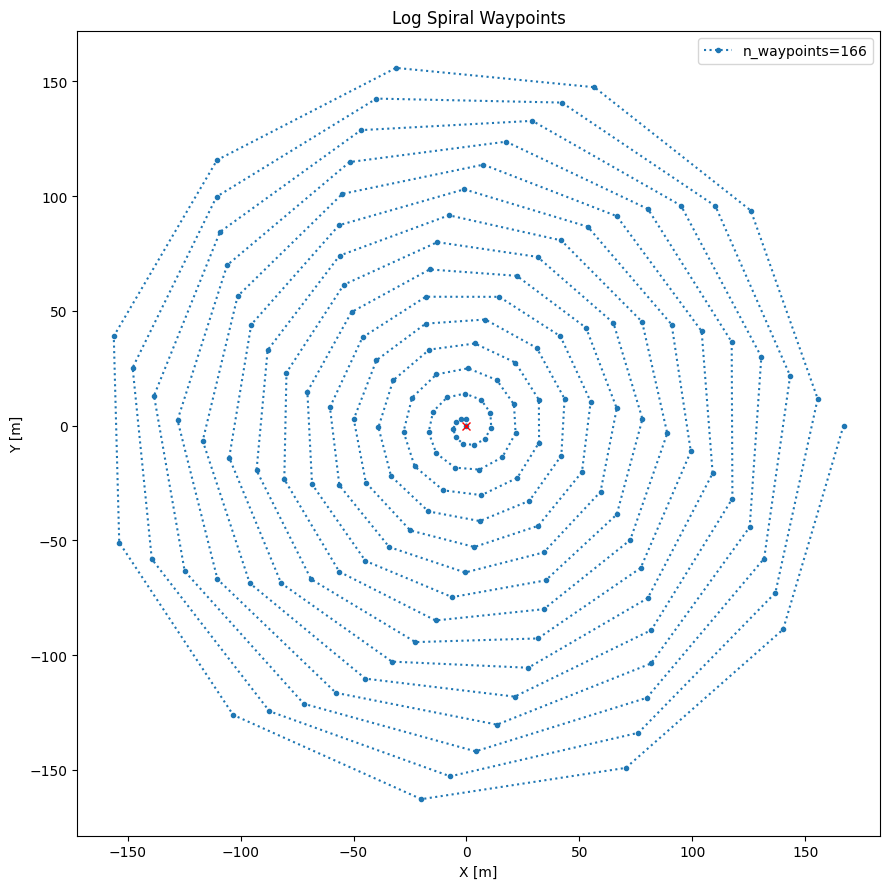

In [31]:
delta=pygeodesy.Ned(50,0,0)
#print(D3A_3m_LatLon.to3llh())
print(WLC_garage_LatLon.to3llh()[:])




xxx,yyy,maggy,ress=Waypoints_Spiral(Altitude=100,RAng=40,dR=1,n_wraps=15)
figure,ax1=subplots(nrows=1,ncols=1,figsize=(9,9))
ax1.plot(xxx,yyy,'.:',label="n_waypoints={}".format(len(xxx)))
ax1.plot(0,0,'rx')
legend()
title("Log Spiral Waypoints")
xlabel('X [m]')
ylabel('Y [m]')
tight_layout()

dx=xxx
dy=yyy
h=100.0*np.ones(len(xxx))
v=5.0*np.ones(len(xxx))
yaw=90.0*np.ones(len(xxx))

with open("../../Desktop/testgrid.csv",'w') as csvfile:
    print("Latitude,Longitude,AltitudeAGL,Speed,UavYaw",file=csvfile)
    print("{},{},0.0,0.0,0.0".format(WLC_garage_LatLon.to3llh()[0],WLC_garage_LatLon.to3llh()[1]),file=csvfile)
    for j in range(len(dx)):
        xx,yy,zz=WLC_garage_LatLon.destinationNed(pygeodesy.Ned(dy[j],dx[j],0.0)).to3llh()
        print("{},{},{},{},{}".format(xx,yy,zz-WLC_garage_LatLon.to3llh()[2]+h[j],v[j],yaw[j]),file=csvfile)

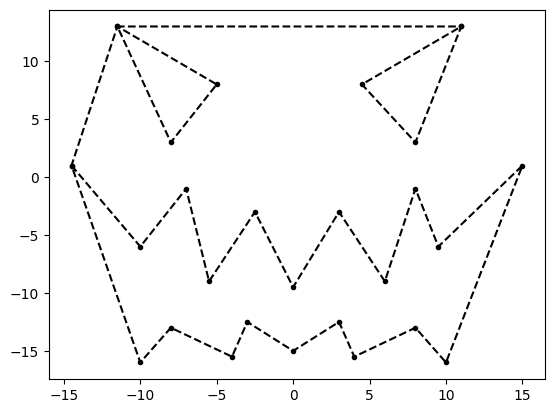

In [34]:
#a=np.array(Image.open("../../Desktop/16671971238146565009845317854060.jpg"))[180:550,354:980]
#a[np.where(a<20)[0],np.where(a<20)[1]]=np.NAN
#plot(np.diff(a)[:,200])
#a[np.where(np.diff(a)>20)[0],np.where(np.diff(a)>20)[1]]
#imshow(a)
#grid()
x=0.05*(np.array([30,120,180,210,270,320,380,440,480,510,620,\
            520,480,400,380,320,260,240,160,120,30,\
            90,220,160,90,540,480,410,540])-320)
y=0.1*(np.array([250,180,230,150,210,145,210,150,230,180,250,\
            80,110,85,115,90,115,85,110,80,250,\
            370,320,270,370,370,270,320,370])-240)

plot(x,y,'k.--')

h=40*np.ones(len(x))
v=3.0*np.ones(len(x))
yaw=0.0*np.ones(len(x))
with open("../../Desktop/Newburgh/flightplans/jack_pol_rot.csv",'w') as csvfile:
    print("Latitude,Longitude,AltitudeAGL,Speed,UavYaw,WaitTime",file=csvfile)
    print(f"49.3220258,-119.6227856,0.0,0.0,0.0,3.0",file=csvfile)
    for j in range(len(x)):
        xx,yy,zz=D3A_3m_LatLon.destinationNed(pygeodesy.Ned(y[j],x[j],0.0)).to3llh()
        for phi in np.arange(0,195,15):
            print("{},{},{},{},{},{}".format(xx,yy,zz-545.2+h[j],v[j],phi,3.0),file=csvfile)

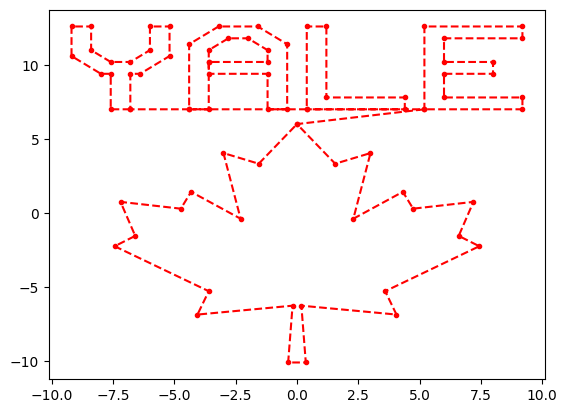

In [36]:
dat=np.loadtxt("../../Desktop/Newburgh/flightplans/yalecoords1.csv",delimiter=',')
xxx=dat[:,0]*2
yyy=10.0+dat[:,1]*2

dat=np.loadtxt("../../Desktop/Newburgh/flightplans/maple2.csv",delimiter=',')
xxx2=(np.nanmax(xxx)/2.0)+dat[:,0]*0.1
yyy2=-35+dat[:,1]*0.1

xxx=0.2*np.concatenate((xxx,xxx2))-9.2
yyy=0.2*np.concatenate((yyy,yyy2))+5

plot(xxx,yyy,'r.--')

h=55*np.ones(len(xxx))
v=3.0*np.ones(len(xxx))
yaw=0.0*np.ones(len(xxx))
with open("../../Desktop/Newburgh/flightplans/yale_maple_d3a.csv",'w') as csvfile:
    print("Latitude,Longitude,AltitudeAGL,Speed,UavYaw",file=csvfile)
    print(f"49.3220258,-119.6227856,0.0,0.0,0.0",file=csvfile)
    for j in range(len(xxx)):
        xx,yy,zz=D3A_3m_LatLon.destinationNed(pygeodesy.Ned(yyy[j],xxx[j],0.0)).to3llh()
        for phi in np.arange(0,195,15):
            print("{},{},{},{},{}".format(xx,yy,zz-545.2+h[j],v[j],phi),file=csvfile)

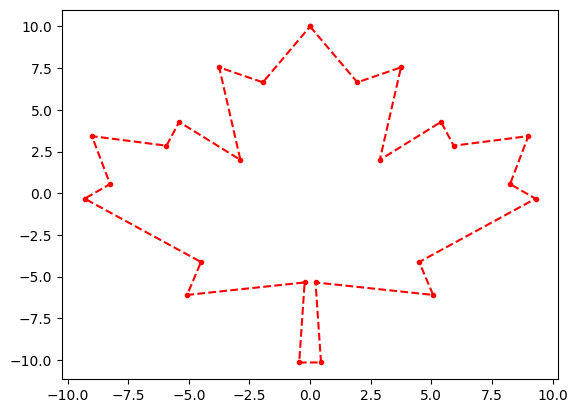

In [37]:
dat=np.loadtxt("../../Desktop/Newburgh/flightplans/maple2.csv",delimiter=',')
xxx=dat[:,0]*0.025
yyy=dat[:,1]*0.025
plot(xxx,yyy,'r.--')


h=55*np.ones(len(xxx))
v=1.0*np.ones(len(xxx))
yaw=0.0*np.ones(len(xxx))
with open("../../Desktop/Newburgh/flightplans/maple_pol_rot.csv",'w') as csvfile:
    print("Latitude,Longitude,AltitudeAGL,Speed,UavYaw,WaitTime",file=csvfile)
    print(f"49.3220258,-119.6227856,0.0,0.0,0.0,3.0",file=csvfile)
    for j in range(len(xxx)):
        xx,yy,zz=D3A_3m_LatLon.destinationNed(pygeodesy.Ned(yyy[j],xxx[j],0.0)).to3llh()
        for phi in np.arange(0,195,15):
            print("{},{},{},{},{},{}".format(xx,yy,zz-545.2+h[j],v[j],phi,3.0),file=csvfile)

In [38]:
gridkeys=["NF3m","FF3m","NF6m","FF6m"]
cornerkeys=["NE","SE","SW","NW"]
for key in gridkeys:
    print(key+" grid centered on {}".format(D3A_3m_LatLon.to3llh()))
    for i,val in enumerate(grid_corners[0]):
        print(i,cornerkeys[i],D3A_3m_LatLon.destinationNed(pygeodesy.Ned(val[0],val[1])).to3llh())


NF3m grid centered on (49.32203, -119.62266, 545.2)
0 NE (49.322118, -119.622525, 545.200015)
1 SE (49.322118, -119.622795, 545.200015)
2 SW (49.321942, -119.622795, 545.200015)
3 NW (49.321942, -119.622525, 545.200015)
FF3m grid centered on (49.32203, -119.62266, 545.2)
0 NE (49.322118, -119.622525, 545.200015)
1 SE (49.322118, -119.622795, 545.200015)
2 SW (49.321942, -119.622795, 545.200015)
3 NW (49.321942, -119.622525, 545.200015)
NF6m grid centered on (49.32203, -119.62266, 545.2)
0 NE (49.322118, -119.622525, 545.200015)
1 SE (49.322118, -119.622795, 545.200015)
2 SW (49.321942, -119.622795, 545.200015)
3 NW (49.321942, -119.622525, 545.200015)
FF6m grid centered on (49.32203, -119.62266, 545.2)
0 NE (49.322118, -119.622525, 545.200015)
1 SE (49.322118, -119.622795, 545.200015)
2 SW (49.321942, -119.622795, 545.200015)
3 NW (49.321942, -119.622525, 545.200015)


In [40]:
# Between the dishes: (49.3220258, -119.6227856)
# potential launch point: (49.3220509, -119.6213817)

# new_latitude  = latitude  + (dy / r_earth) * (180 / np.pi);
# new_longitude = longitude + (dx / r_earth) * (180 / np.pi) / cos(latitude * pi/180);

In [45]:
np.linspace(800,400,1024)[250:400]

array([702.24828935, 701.8572825 , 701.46627566, 701.07526882,
       700.68426197, 700.29325513, 699.90224829, 699.51124145,
       699.1202346 , 698.72922776, 698.33822092, 697.94721408,
       697.55620723, 697.16520039, 696.77419355, 696.38318671,
       695.99217986, 695.60117302, 695.21016618, 694.81915934,
       694.42815249, 694.03714565, 693.64613881, 693.25513196,
       692.86412512, 692.47311828, 692.08211144, 691.69110459,
       691.30009775, 690.90909091, 690.51808407, 690.12707722,
       689.73607038, 689.34506354, 688.9540567 , 688.56304985,
       688.17204301, 687.78103617, 687.39002933, 686.99902248,
       686.60801564, 686.2170088 , 685.82600196, 685.43499511,
       685.04398827, 684.65298143, 684.26197458, 683.87096774,
       683.4799609 , 683.08895406, 682.69794721, 682.30694037,
       681.91593353, 681.52492669, 681.13391984, 680.742913  ,
       680.35190616, 679.96089932, 679.56989247, 679.17888563,
       678.78787879, 678.39687195, 678.0058651 , 677.61